=== backtest_30d (2025-03-30 - 2025-04-28) ===
deposits:145  withdraws:55


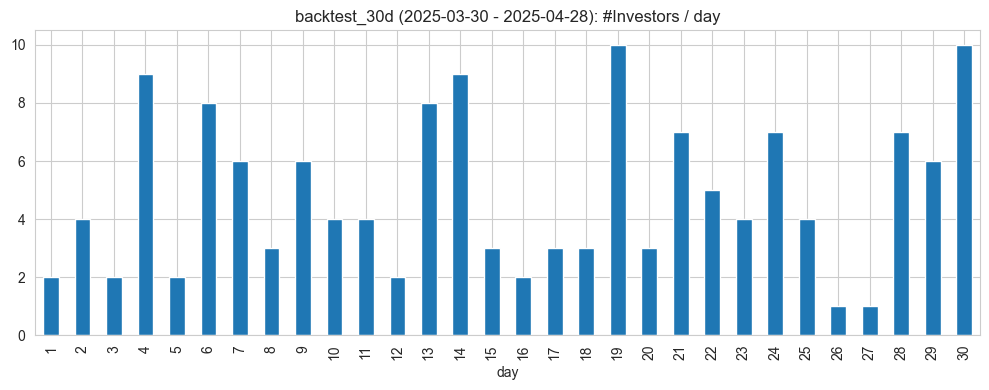

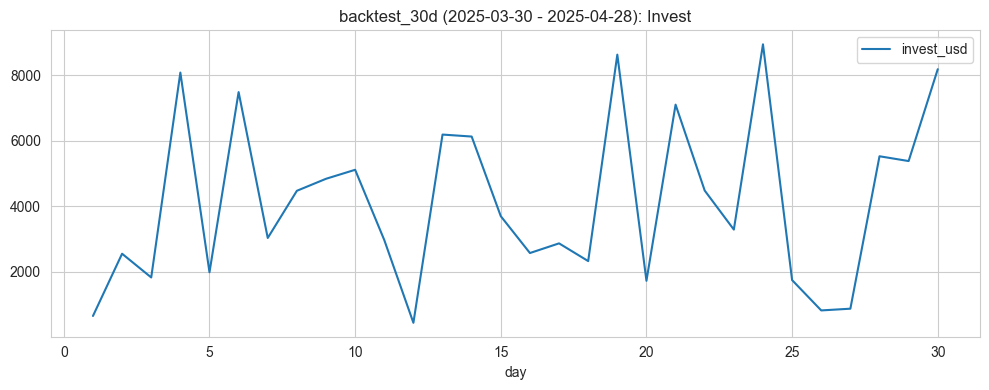

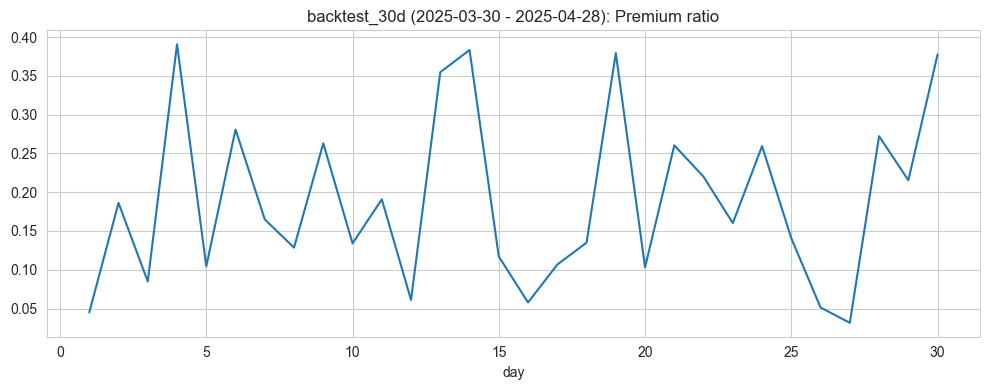

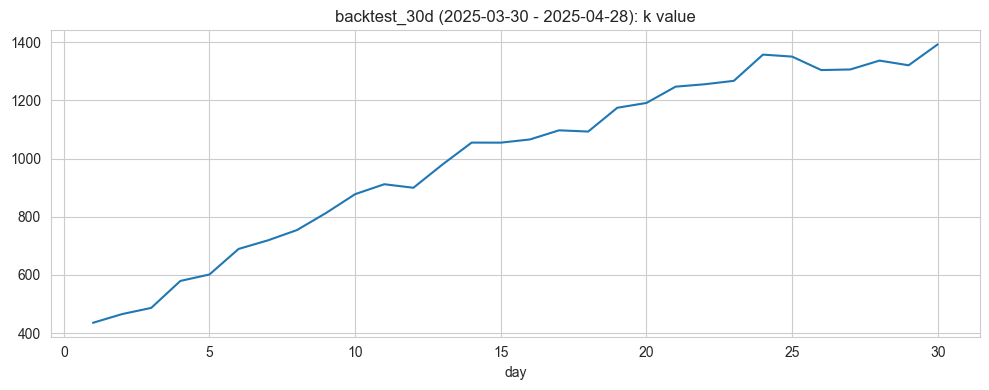

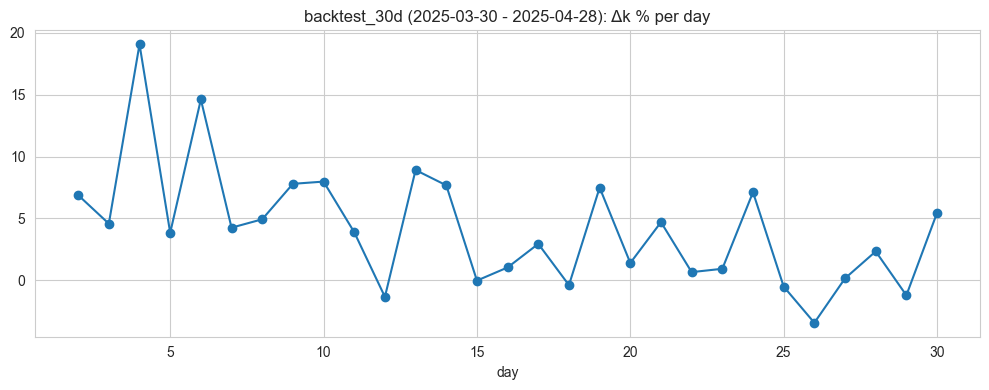

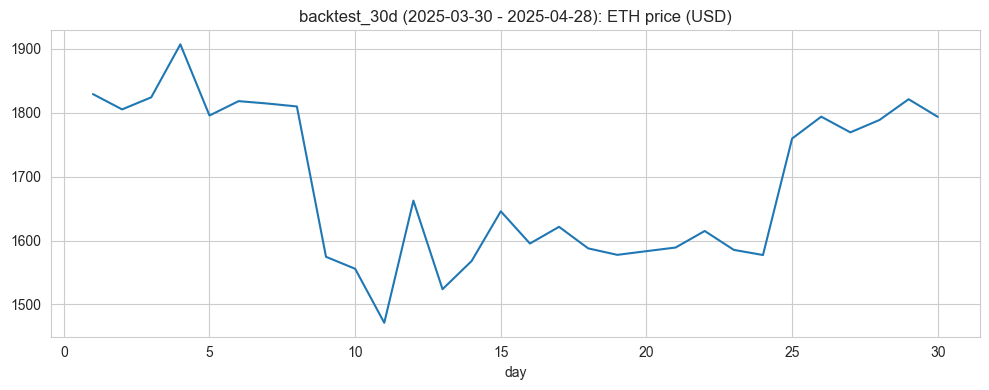

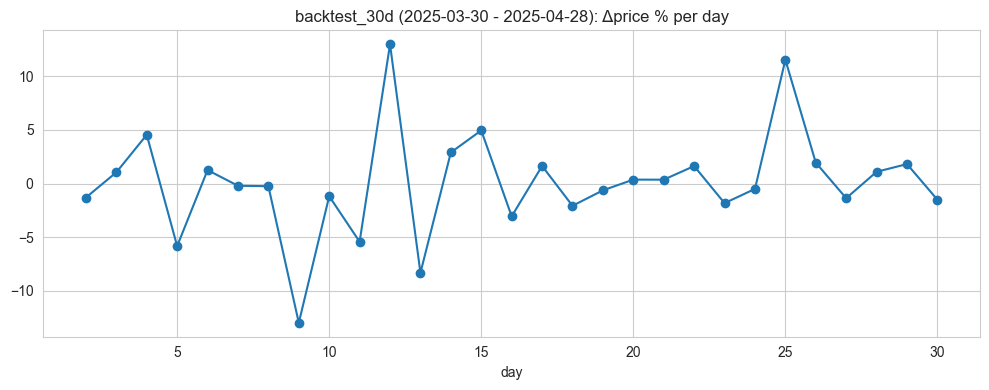

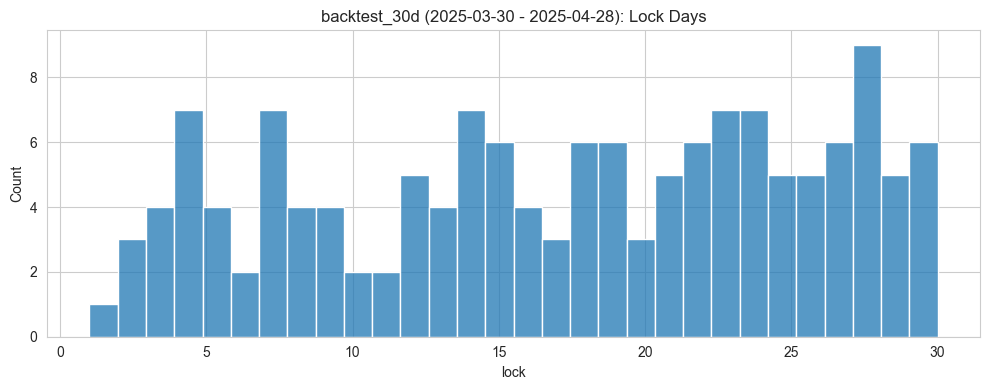

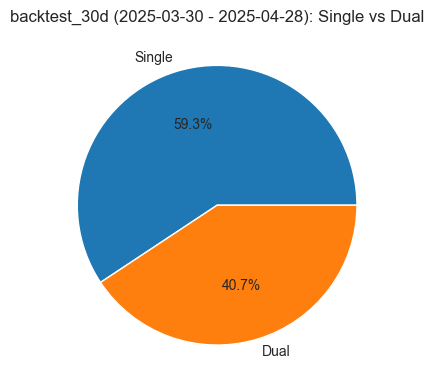

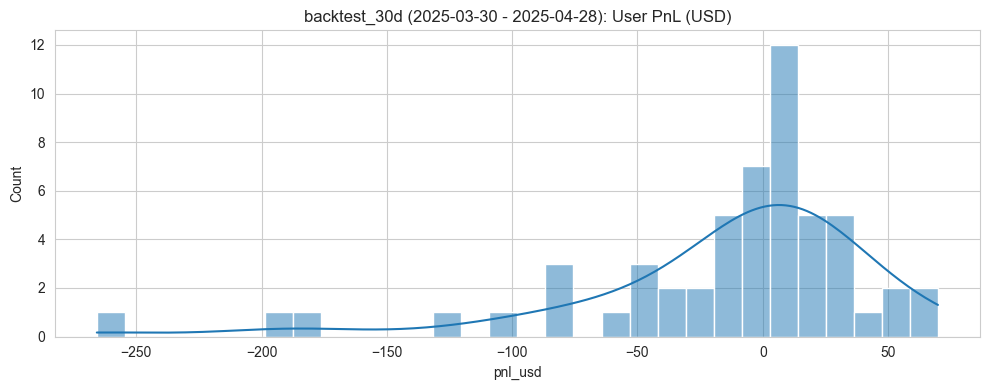

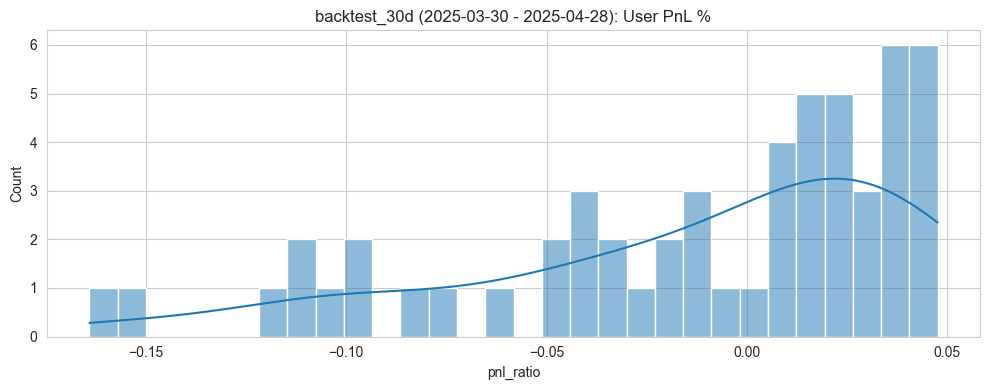

=== backtest_60d (2025-02-28 - 2025-04-28) ===
deposits:356  withdraws:252


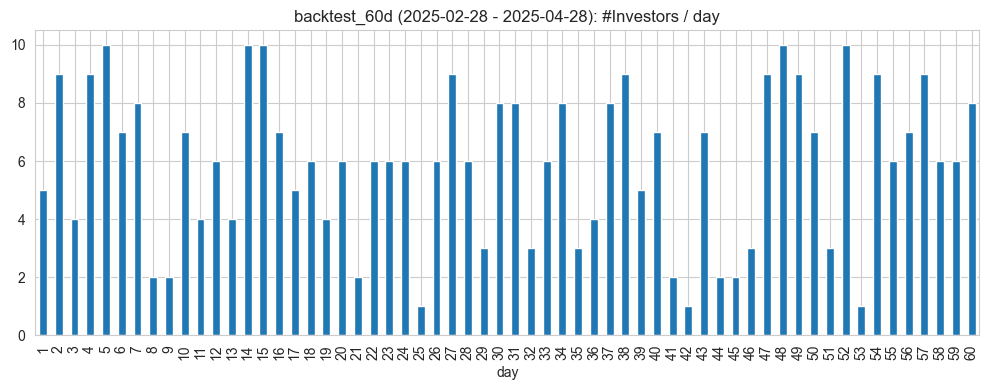

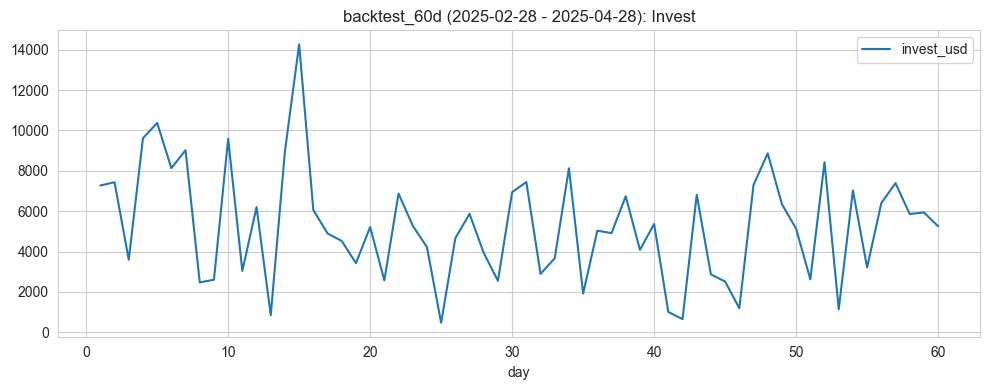

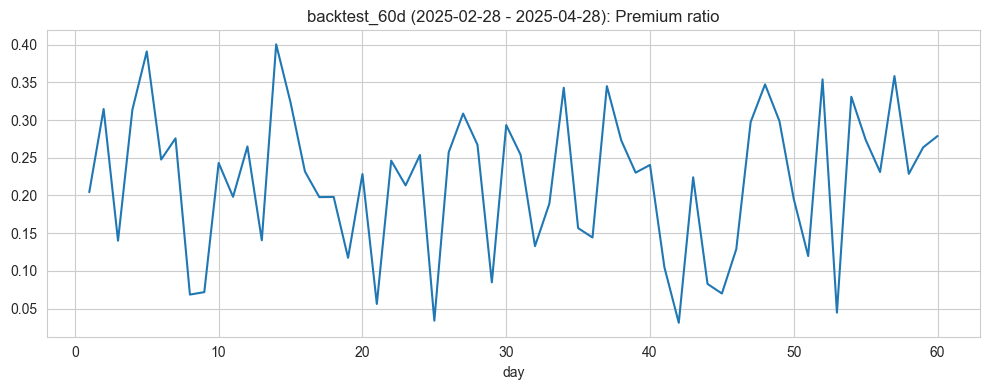

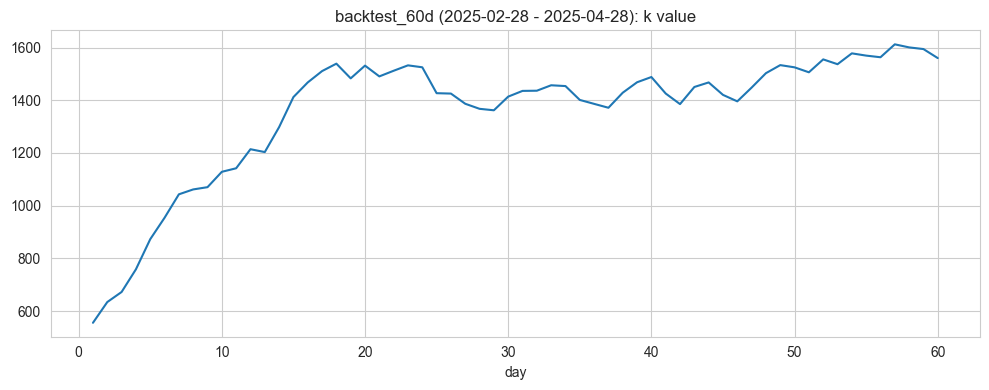

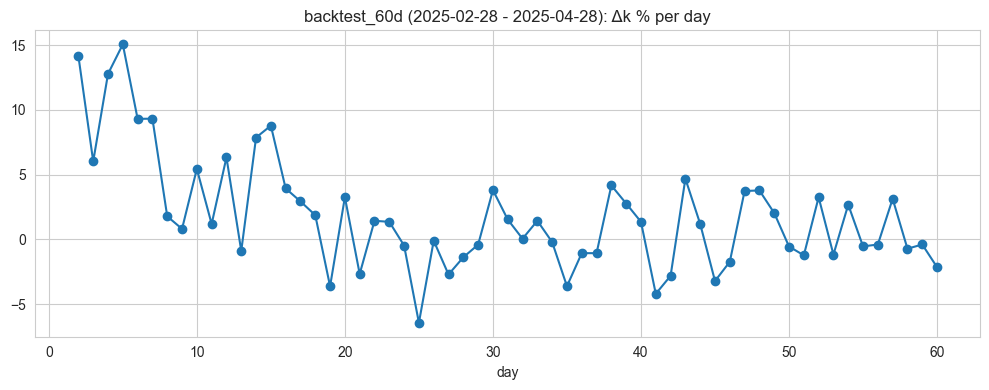

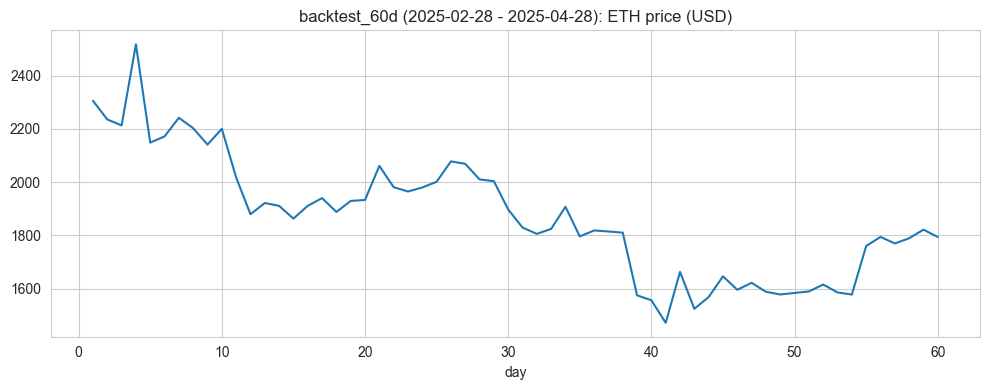

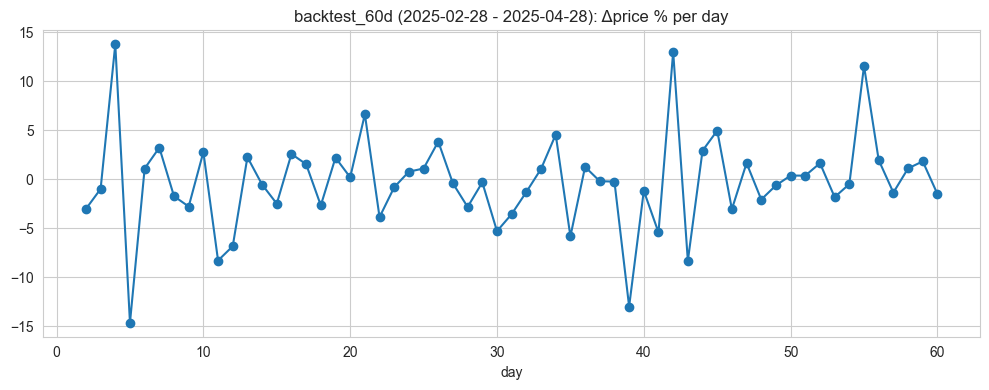

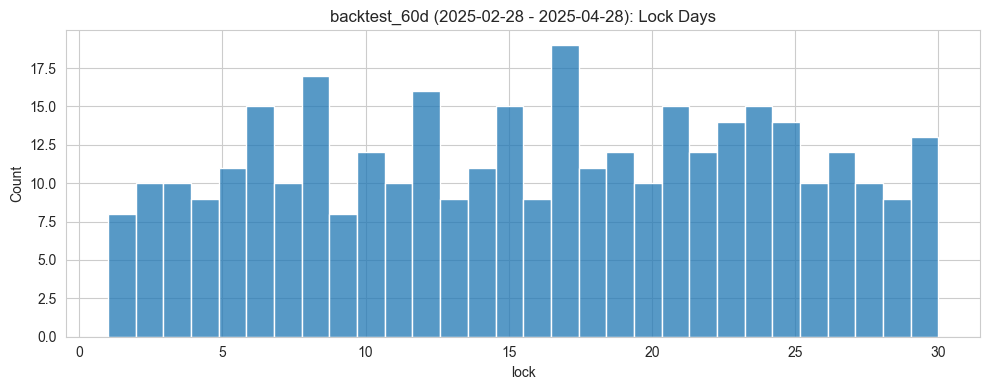

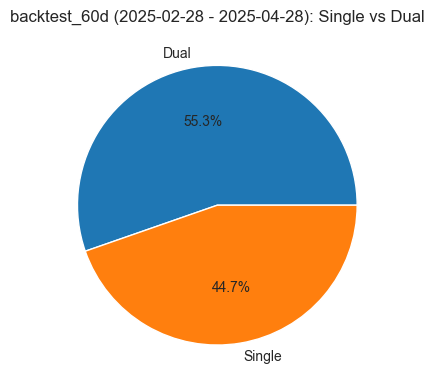

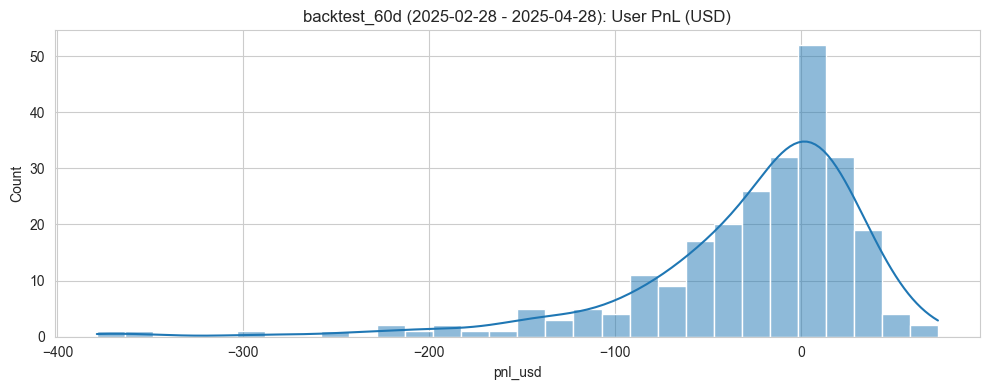

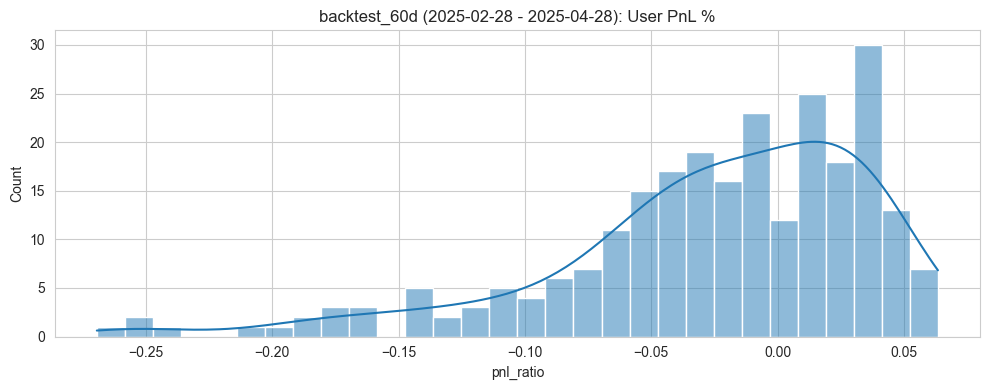

=== backtest_90d (2025-01-29 - 2025-04-28) ===
deposits:498  withdraws:417


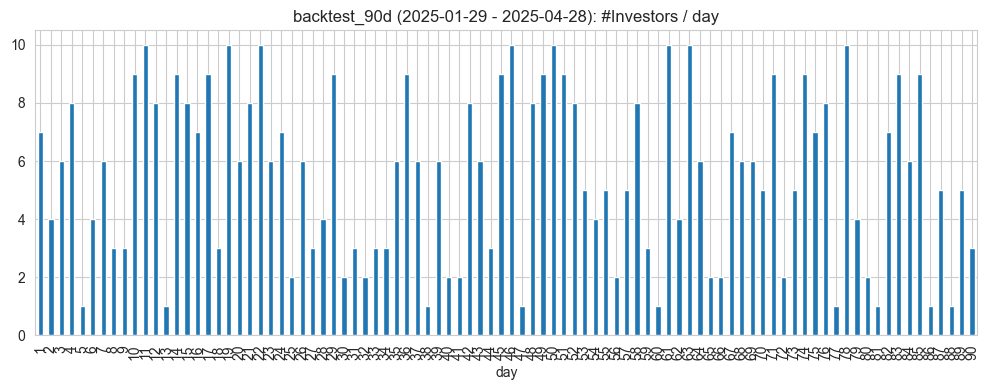

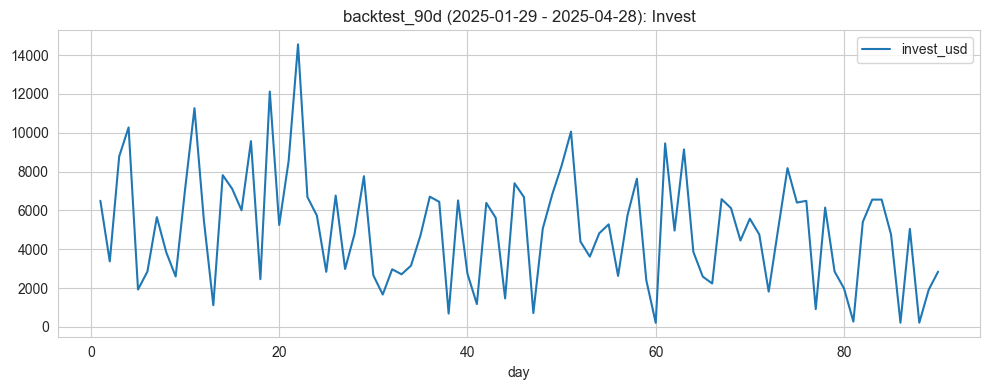

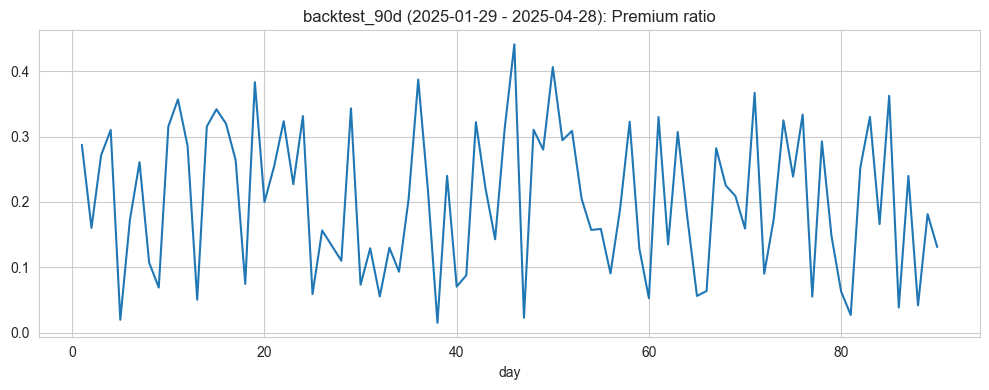

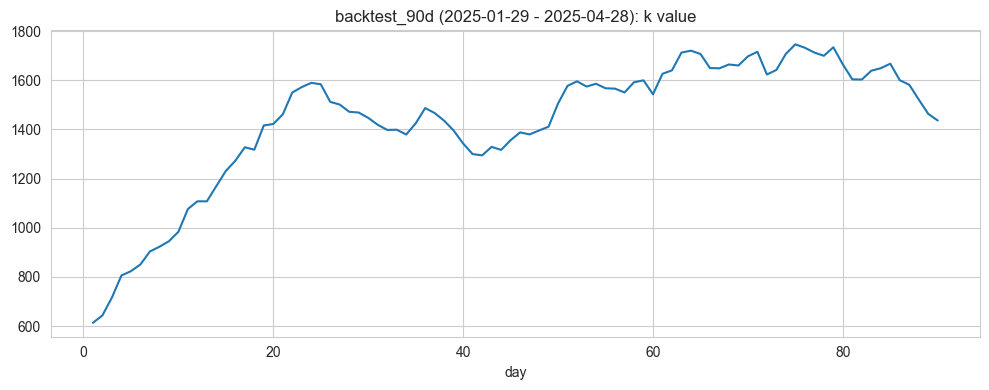

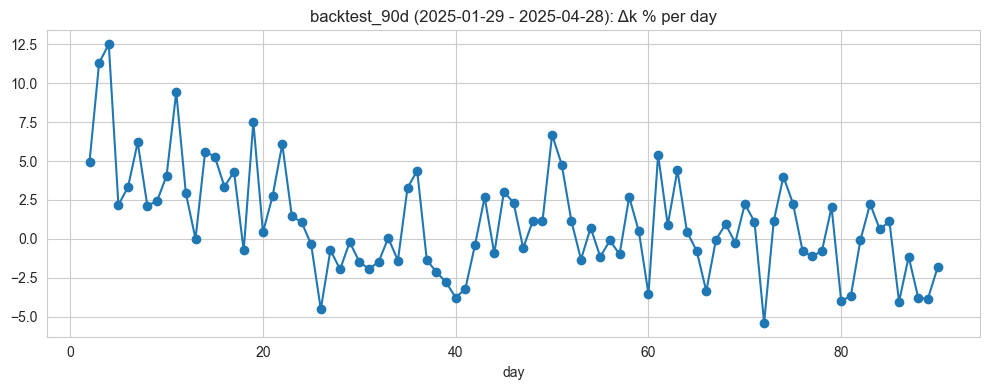

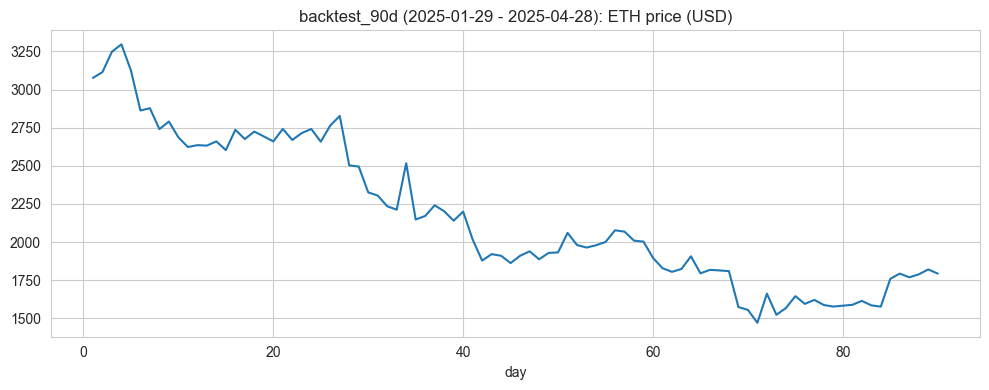

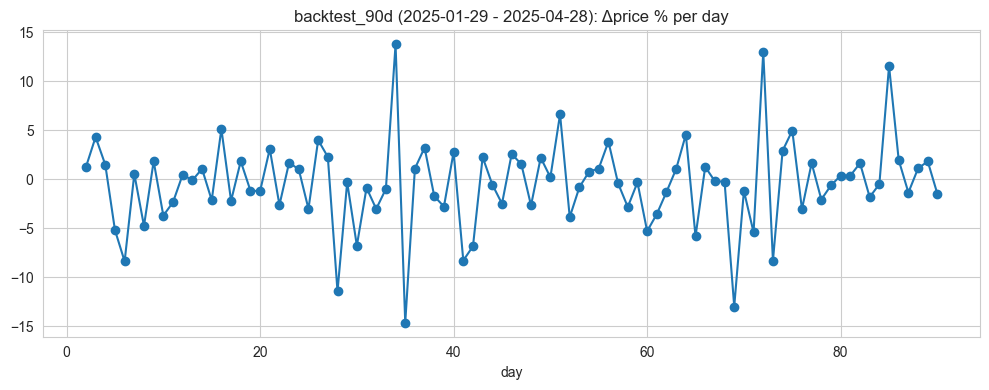

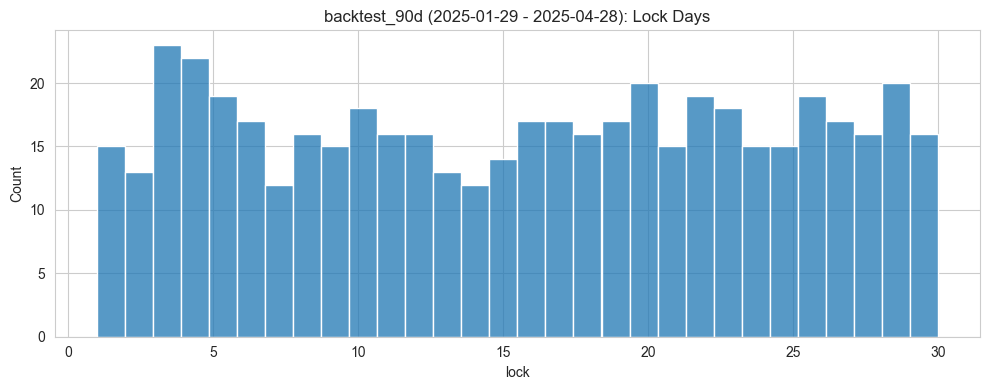

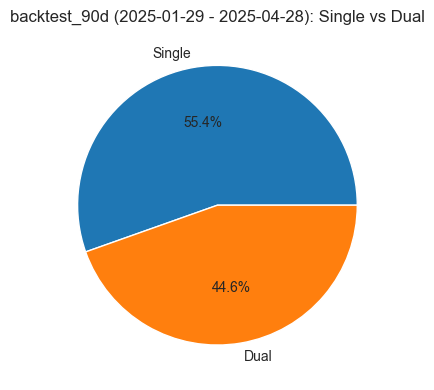

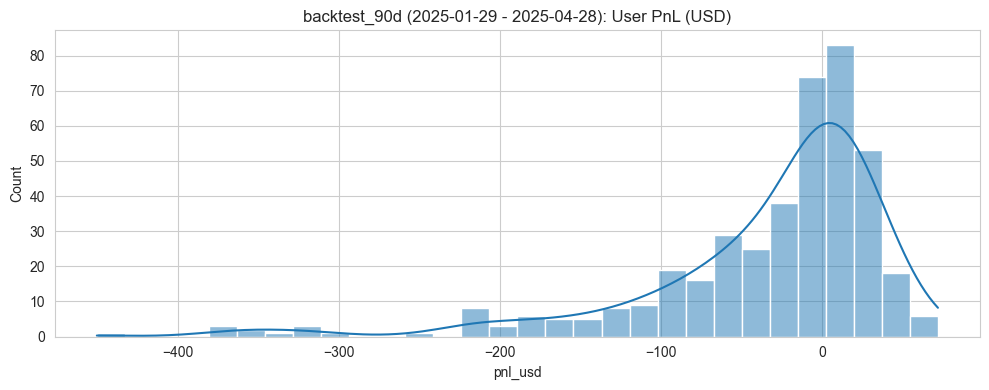

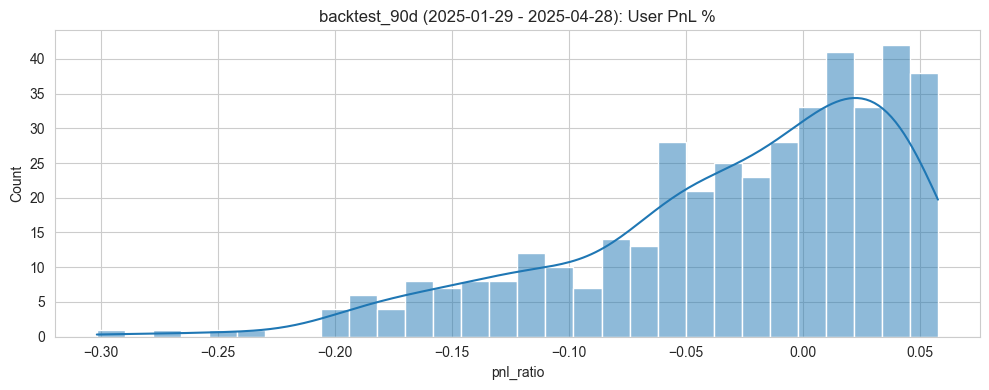

In [1]:
import sys, pathlib; sys.path.append("backtest_module")
from backtest import BacktestRunner
from analyzer import Analyzer

horizons = [30, 60, 90]        
results  = {}

for h in horizons:
    runner = BacktestRunner(h)
    start_date, end_date = runner.get_start_end_dates()
    tag = f"backtest_{h}d ({start_date} - {end_date})"

    deposit_df, withdraw_df, daily_snapshot = runner.run()
    results[h]    = (deposit_df, withdraw_df, daily_snapshot)

    print(f"=== {tag} ===")
    print(f"deposits:{len(deposit_df)}  withdraws:{len(withdraw_df)}")
    Analyzer(deposit_df, withdraw_df, daily_snapshot, tag).all_plots()